In [13]:
import xarray as xr
import data_types
import importlib
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
import seaborn

years=range(2020,2021)
months=range(1,2)

data_dir = '/scratch/cimes/feiyul/Ocean_Data'
# data_dir = '/collab1/data_untrusted/Feiyu.Lu/Ocean_Data'
T_varname = 'thetao_prior_z'
S_varname = 'so_prior_z'
SST_obs_varname = 'sst'
SSS_obs_varname = 'sss'

ocean_static_ds = xr.open_dataset(f'{data_dir}/model_data/M9/ocean_z.static.nc')
ocean_static_ds['xh']=ocean_static_ds['xh'].where(ocean_static_ds['xh']>0,ocean_static_ds['xh']+360)
ocean_static_ds['xq']=ocean_static_ds['xq'].where(ocean_static_ds['xq']>0,ocean_static_ds['xq']+360)
ocean_static_ds_rolled = ocean_static_ds.roll(xh=60,roll_coords=True).roll(xq=60,roll_coords=True)
geolat= ocean_static_ds_rolled.geolat
geolon= ocean_static_ds_rolled.geolon

ocean_levels_ds = xr.open_dataset(f'{data_dir}/model_data/M9/vgrid_75_2m.nc')
ocean_levels = ocean_levels_ds.dz

T_ds = xr.open_mfdataset(
    [f'{data_dir}/model_data/M9/ocean_daily.{year}0101-{year}1231.{T_varname}.nc' for year in years])
T_ds['xh']=T_ds['xh'].where(T_ds['xh']>0,T_ds['xh']+360)
T_ds_rolled = T_ds.roll(xh=60,roll_coords=True)
T_var = T_ds_rolled[T_varname]

SST_obs_ds = xr.open_mfdataset(
    [f'{data_dir}/obs_data/sst/sst.day.{year}.1x1.nc' for year in years])
SST_obs_var = SST_obs_ds[SST_obs_varname]

SSS_obs_ds = xr.open_mfdataset(
    [f'{data_dir}/obs_data/sss/SSS.day.{year}.1x1.nc' for year in years])
SSS_obs_var = SSS_obs_ds[SSS_obs_varname]

argo_obs_ds = xr.open_mfdataset(
    [f'{data_dir}/obs_data/argo/argo_{year}.nc' for year in years])

In [14]:
argo_obs_ds

<xarray.Dataset>
Dimensions:          (grid_longitude: 73, grid_latitude: 37, depth_index: 50,
                      station_index: 1020305)
Coordinates:
  * grid_longitude   (grid_longitude) float32 0.0 5.0 10.0 ... 350.0 355.0 360.0
  * grid_latitude    (grid_latitude) float32 -90.0 -85.0 -80.0 ... 85.0 90.0
  * depth_index      (depth_index) float32 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
  * station_index    (station_index) float64 1.0 2.0 3.0 ... 8.675e+04 8.675e+04
Data variables: (12/14)
    longitude_index  (station_index) float32 dask.array<chunksize=(1020305,), meta=np.ndarray>
    latitude_index   (station_index) float32 dask.array<chunksize=(1020305,), meta=np.ndarray>
    longitude        (station_index) float32 dask.array<chunksize=(1020305,), meta=np.ndarray>
    latitude         (station_index) float32 dask.array<chunksize=(1020305,), meta=np.ndarray>
    time             (station_index) datetime64[ns] dask.array<chunksize=(1020305,), meta=np.ndarray>
    mmddyyyy         (station_index) float32 dask.array<chunksize=(1020305,), meta=np.ndarray>
    ...               ...
    depth            (station_index, depth_index) float32 dask.array<chunksize=(1020305, 50), meta=np.ndarray>
    temp             (station_index, depth_index) float32 dask.array<chunksize=(1020305, 50), meta=np.ndarray>
    salt             (station_index, depth_index) float32 dask.array<chunksize=(1020305, 50), meta=np.ndarray>
    dens_flag        (station_index, depth_index) float32 dask.array<chunksize=(1020305, 50), meta=np.ndarray>
    type             (station_index) float32 dask.array<chunksize=(1020305,), meta=np.ndarray>
    link             (station_index) float32 dask.array<chunksize=(1020305,), meta=np.ndarray>
Attributes:
    filename:        argo.nc
    MPP_IO_VERSION:  $Id: mpp_io.F90,v 6.7 2003/04/09 21:17:55 fms Exp $
    history:         Mon Jan  4 13:14:50 2021: ncrcat /lustre/f2/pdata/gfdl/g...
    NCO:             netCDF Operators version 4.7.9 (Homepage = http://nco.sf...

In [4]:
T_var

<xarray.DataArray 'thetao_prior_z' (time: 366, z: 75, yh: 320, xh: 360)>
dask.array<rechunk-merge, shape=(366, 75, 320, 360), dtype=float32, chunksize=(366, 75, 320, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2020-01-01 12:00:00 ... 2020-12-31 12:00:00
  * xh       (xh) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * yh       (yh) float64 -77.77 -77.56 -77.34 -77.12 ... 89.26 89.48 89.69 89.9
  * z        (z) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
Attributes:
    units:          degC
    long_name:      Accumulated ocean potential temperature for DA/ML
    cell_methods:   area:mean z:mean yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [5]:
SST_obs_var

<xarray.DataArray 'sst' (time: 366, lat: 180, lon: 360)>
dask.array<open_dataset-8bebdd16df85fd9e11cabb4df7a0e3d8sst, shape=(366, 180, 360), dtype=float32, chunksize=(366, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) object 2020-01-01 00:00:00 ... 2020-12-31 00:00:00
Attributes:
    long_name:              SST1[GT=TDAY]
    typeConversion_op_ncl:  double converted to float

In [15]:
# importlib.reload(data_types)
argo_obs = data_types.argo(argo_obs_ds,nread=100000,nstart=30000)
len(argo_obs)

17153

2020-01-18T05:15:00.000000000
2020-01-18T05:15:00.000000000
22.132
240.38


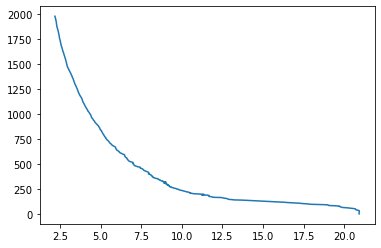

In [16]:
print(argo_obs.profiles[-1].time)
print(argo_obs.time[-1])
print(argo_obs.lat[-1])
print(argo_obs.lon[-1])
plt.plot(argo_obs.profiles[-1].T, argo_obs.profiles[-1].depth,label='Argo T')

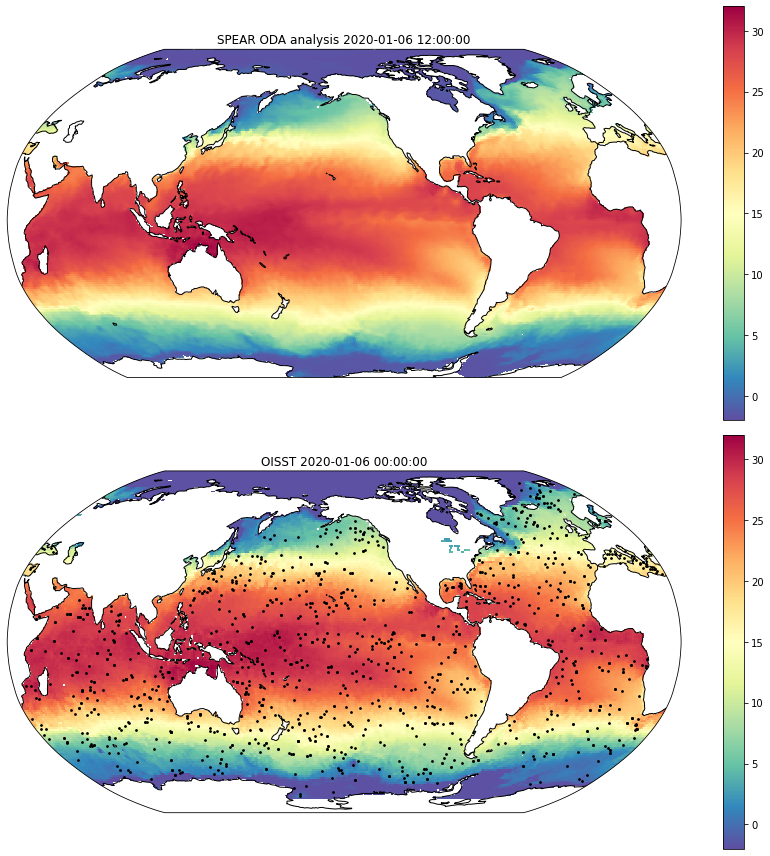

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,12),
                         subplot_kw={'projection': ccrs.Robinson(210)})

day = 5
period = [np.datetime64('2020-01-03T00:00:00'),
          np.datetime64('2020-01-08T00:00:00')]

indexes = argo_obs.get_profiles_by_all(
    start_time=period[0], end_time=period[1])
    
level = 0
cmap = seaborn.color_palette("Spectral_r", as_cmap=True)

cf0=axes[0].pcolormesh(
    geolon, 
    geolat, 
    T_var.isel(z=level,time=day), 
    vmin=-2, vmax=32, cmap=cmap,
    transform = ccrs.PlateCarree())

cf1=axes[1].pcolormesh(
    SST_obs_var.lon,
    SST_obs_var.lat,
    SST_obs_var.isel(time=day), 
    vmin=-2, vmax=32, cmap=cmap,
    transform = ccrs.PlateCarree())
    
axes[1].scatter(argo_obs.lon[indexes], argo_obs.lat[indexes], 
                s=3, color='black', transform = ccrs.PlateCarree())

axes[0].set_title(f'SPEAR ODA analysis {T_var.time.isel(time=day).values}')
axes[1].set_title(f'OISST {SST_obs_var.time.isel(time=day).values}')
fig.colorbar(cf0, ax=axes[0])
fig.colorbar(cf1, ax=axes[1])

for ax in axes:
    ax.coastlines()

fig.tight_layout()

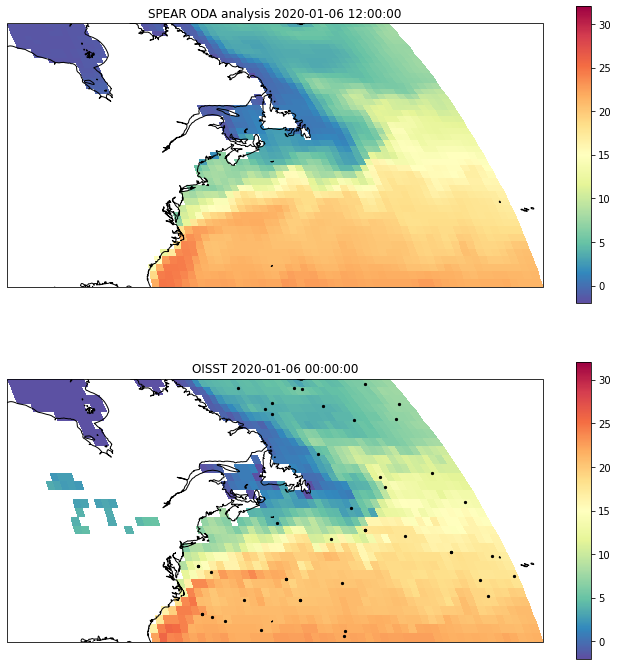

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,12),
                         subplot_kw={'projection': ccrs.Robinson(210)})

day = 5
period = [np.datetime64('2020-01-03T00:00:00'),
          np.datetime64('2020-01-08T00:00:00')]
lat_min = 30
lat_max = 60
lon_min = 270
lon_max = 330

indexes = argo_obs.get_profiles_by_all(
    start_time=period[0], end_time=period[1],
    lat_min=lat_min,lat_max=lat_max,lon_min=lon_min,lon_max=lon_max)
level = 0
cmap = seaborn.color_palette("Spectral_r", as_cmap=True)

cf0=axes[0].pcolormesh(
    geolon.sel(xh=slice(lon_min,lon_max),yh=slice(lat_min,lat_max)), 
    geolat.sel(xh=slice(lon_min,lon_max),yh=slice(lat_min,lat_max)), 
    T_var.isel(z=level,time=day).sel(xh=slice(lon_min,lon_max),yh=slice(lat_min,lat_max)), 
    vmin=-2, vmax=32, cmap=cmap,
    transform = ccrs.PlateCarree())

cf1=axes[1].pcolormesh(
    SST_obs_var.lon.sel(lon=slice(lon_min,lon_max)),
    SST_obs_var.lat.sel(lat=slice(lat_min,lat_max)),
    SST_obs_var.isel(time=day).sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max)), 
    vmin=-2, vmax=32, cmap=cmap,
    transform = ccrs.PlateCarree())

axes[1].scatter(argo_obs.lon[indexes], argo_obs.lat[indexes], 
                s=5, color='black', transform = ccrs.PlateCarree())

axes[0].set_title(f'SPEAR ODA analysis {T_var.time.isel(time=day).values}')
axes[1].set_title(f'OISST {SST_obs_var.time.isel(time=day).values}')
fig.colorbar(cf0, ax=axes[0])
fig.colorbar(cf1, ax=axes[1])

for ax in axes:
    ax.coastlines()

# fig.tight_layout()